In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# Settings
seq_len = 24
n_seq = 6
sample_path = Path("time_gan")
hdf_store = sample_path / "TimeSeriesGAN.h5"
synthetic_path = sample_path / "experiment_00" / "generated_data.npy"

In [3]:
# --- Load real and synthetic data ---
def get_real_data():
    df = pd.read_hdf(hdf_store, 'data/real').sort_index()
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return np.array(data)

real_data = get_real_data()
synthetic_data = np.load(synthetic_path)


In [4]:
# --- Align data lengths ---
real_data = real_data[:len(synthetic_data)]

print(f"Real data shape: {real_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")

Real data shape: (5248, 24, 6)
Synthetic data shape: (5248, 24, 6)


In [5]:
# --- Split into train/test ---
n_samples = real_data.shape[0]
n_train = int(0.8 * n_samples)
train_idx = np.arange(n_train)
test_idx = np.arange(n_train, n_samples)

In [6]:
# --- Format for Random Forest (flattened sequences) ---
X_real_train = real_data[train_idx, :-1, :].reshape(n_train, -1)
y_real_train = real_data[train_idx, -1, :]

X_real_test = real_data[test_idx, :-1, :].reshape(n_samples - n_train, -1)
y_real_test = real_data[test_idx, -1, :]

X_syn_train = synthetic_data[train_idx, :-1, :].reshape(n_train, -1)
y_syn_train = synthetic_data[train_idx, -1, :]

In [8]:
# --- Train on Synthetic ---
rf_syn = RandomForestRegressor(n_estimators=100, random_state=42)
rf_syn.fit(X_syn_train, y_syn_train)
y_pred_syn = rf_syn.predict(X_real_test)

mae_syn = mean_absolute_error(y_real_test, y_pred_syn)
rmse_syn = np.sqrt(mean_squared_error(y_real_test, y_pred_syn))
r2_syn = r2_score(y_real_test, y_pred_syn)

In [9]:
# --- Train on Real ---
rf_real = RandomForestRegressor(n_estimators=100, random_state=42)
rf_real.fit(X_real_train, y_real_train)
y_pred_real = rf_real.predict(X_real_test)

mae_real = mean_absolute_error(y_real_test, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real_test, y_pred_real))
r2_real = r2_score(y_real_test, y_pred_real)

In [10]:
# --- Train on Real + Synthetic ---
X_combined = np.concatenate([X_real_train, X_syn_train])
y_combined = np.concatenate([y_real_train, y_syn_train])
rf_comb = RandomForestRegressor(n_estimators=100, random_state=42)
rf_comb.fit(X_combined, y_combined)
y_pred_comb = rf_comb.predict(X_real_test)

mae_comb = mean_absolute_error(y_real_test, y_pred_comb)
rmse_comb = np.sqrt(mean_squared_error(y_real_test, y_pred_comb))
r2_comb = r2_score(y_real_test, y_pred_comb)

In [11]:

# --- Report all scores ---
print("\n Evaluation Results:")
print(f"Train on Real → Test on Real:    MAE={mae_real:.4f}, RMSE={rmse_real:.4f}, R²={r2_real:.4f}")
print(f"Train on Synthetic → Test on Real: MAE={mae_syn:.4f}, RMSE={rmse_syn:.4f}, R²={r2_syn:.4f}")
print(f"Train on Real+Synthetic → Test on Real: MAE={mae_comb:.4f}, RMSE={rmse_comb:.4f}, R²={r2_comb:.4f}")


 Evaluation Results:
Train on Real → Test on Real:    MAE=0.2243, RMSE=0.2868, R²=-2.4172
Train on Synthetic → Test on Real: MAE=0.0870, RMSE=0.1147, R²=0.2075
Train on Real+Synthetic → Test on Real: MAE=0.0964, RMSE=0.1341, R²=0.0392


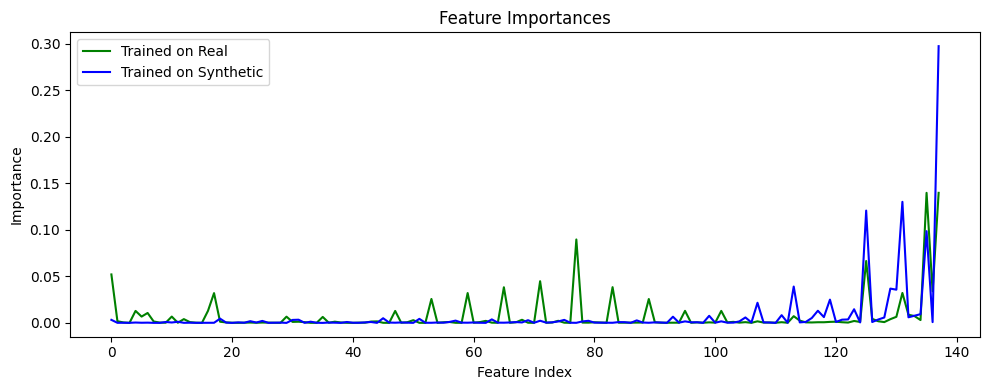

In [12]:
# --- Feature Importances ---
plt.figure(figsize=(10, 4))
plt.plot(rf_real.feature_importances_, label='Trained on Real', color='green')
plt.plot(rf_syn.feature_importances_, label='Trained on Synthetic', color='blue')
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.legend()
plt.tight_layout()
plt.show()

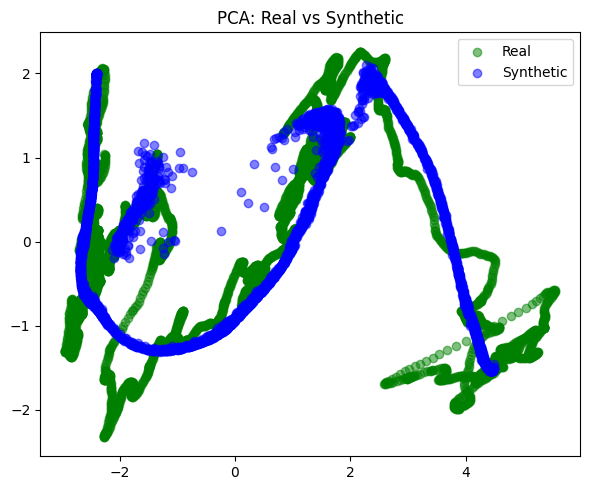

In [13]:
# --- PCA Distribution Comparison ---
pca = PCA(n_components=2)
real_flat = real_data.reshape(len(real_data), -1)
synthetic_flat = synthetic_data.reshape(len(synthetic_data), -1)

real_pca = pca.fit_transform(real_flat)
synthetic_pca = pca.transform(synthetic_flat)

plt.figure(figsize=(6, 5))
plt.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.5, label='Real', color='green')
plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], alpha=0.5, label='Synthetic', color='blue')
plt.title("PCA: Real vs Synthetic")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# --- MMD (statistical distance) ---
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return xx.mean() + yy.mean() - 2 * xy.mean()

mmd_val = compute_mmd(real_flat, synthetic_flat)
print(f"\n Maximum Mean Discrepancy (MMD) between real and synthetic: {mmd_val:.4f}")


 Maximum Mean Discrepancy (MMD) between real and synthetic: 0.0394


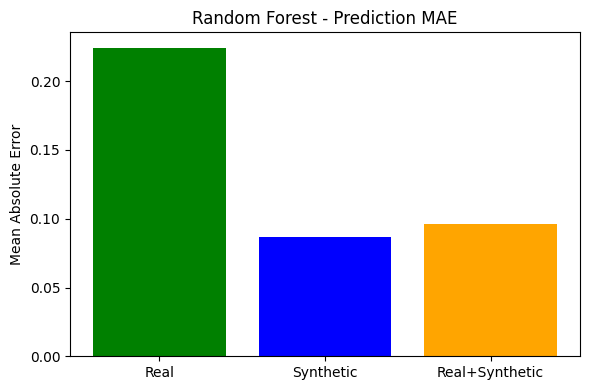

In [15]:
# --- MAE bar plot ---
plt.figure(figsize=(6, 4))
plt.bar(['Real', 'Synthetic', 'Real+Synthetic'], [mae_real, mae_syn, mae_comb], color=['green', 'blue', 'orange'])
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest - Prediction MAE')
plt.tight_layout()
plt.show()